
==================== TESTES DE HIPÓTESE ====================


===== landform ~ ros_p =====
Kruskal-Wallis H = 27.4979, p = 0.002171

===== landform ~ log(ros_p) =====
Kruskal-Wallis H = 27.4979, p = 0.002171

===== land_use ~ ros_p =====
Kruskal-Wallis H = 24.2886, p = 0.001014

===== land_use ~ log(ros_p) =====
Kruskal-Wallis H = 24.2886, p = 0.001014

===== fuel_model ~ ros_p =====
Kruskal-Wallis H = 27.2610, p = 0.007086

===== fuel_model ~ log(ros_p) =====
Kruskal-Wallis H = 27.2610, p = 0.007086

===== Haines_av ~ ros_p =====
Kruskal-Wallis H = 2.1239, p = 0.145013

===== Haines_av ~ log(ros_p) =====
Kruskal-Wallis H = 2.1239, p = 0.145013


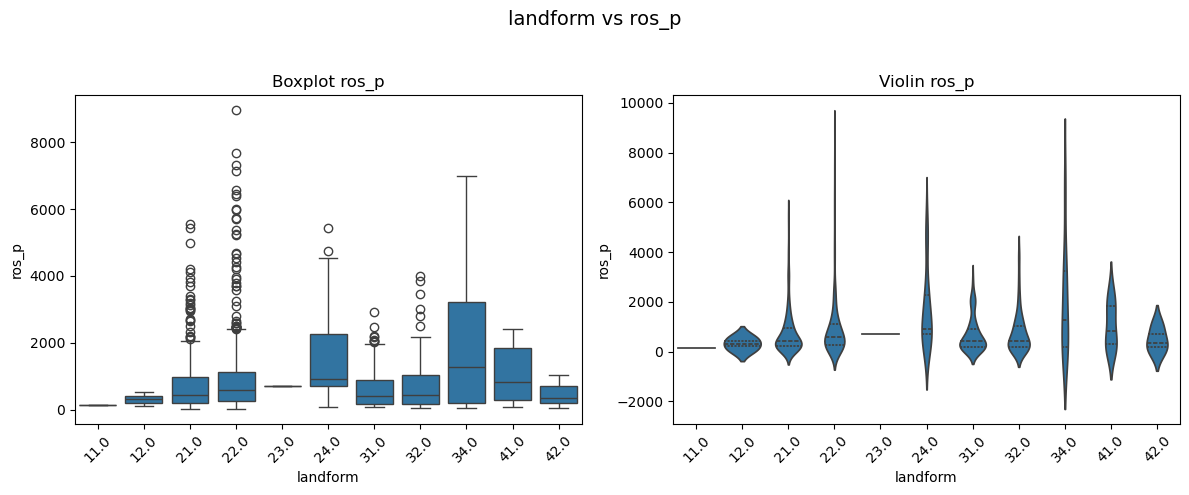

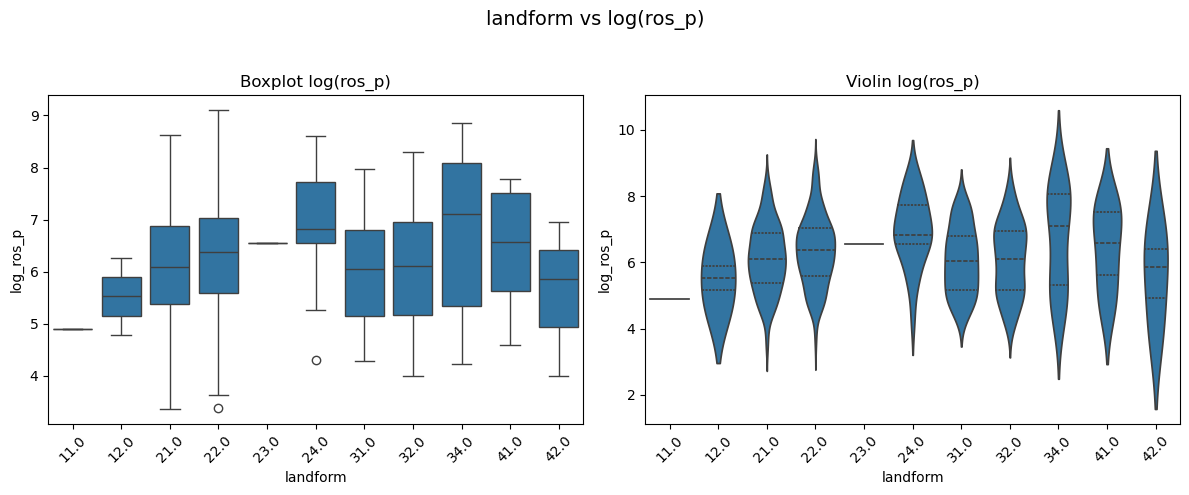

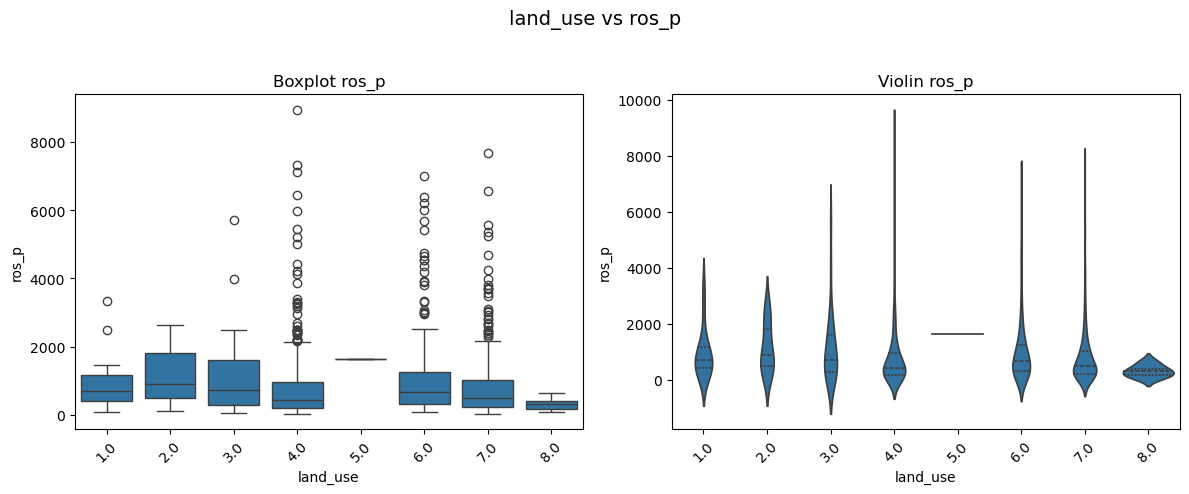

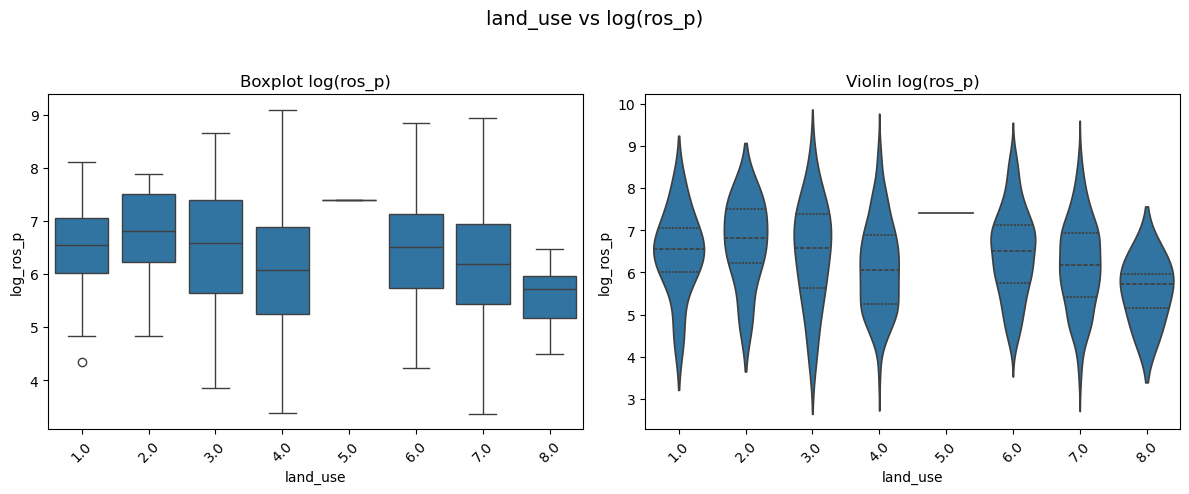

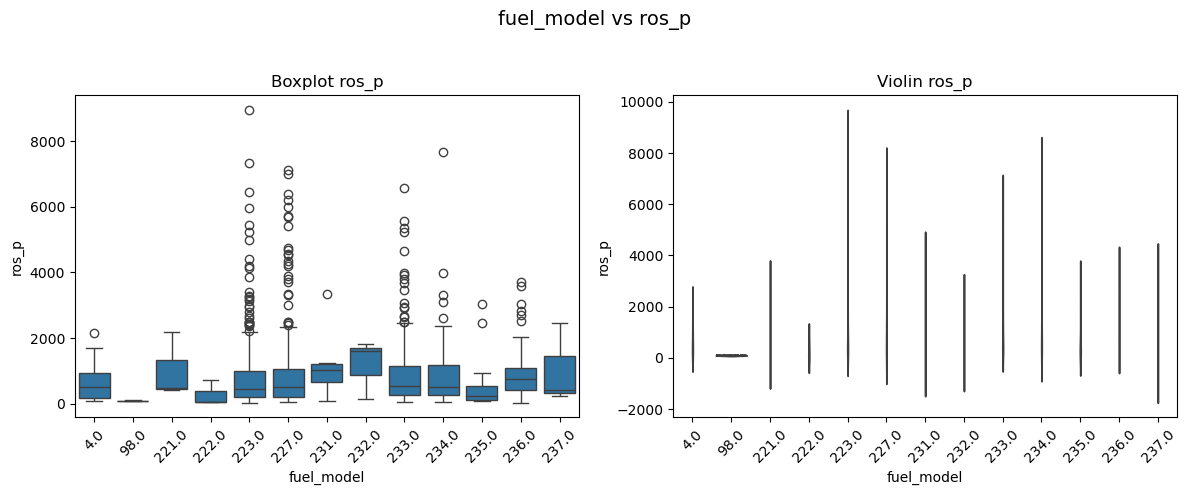

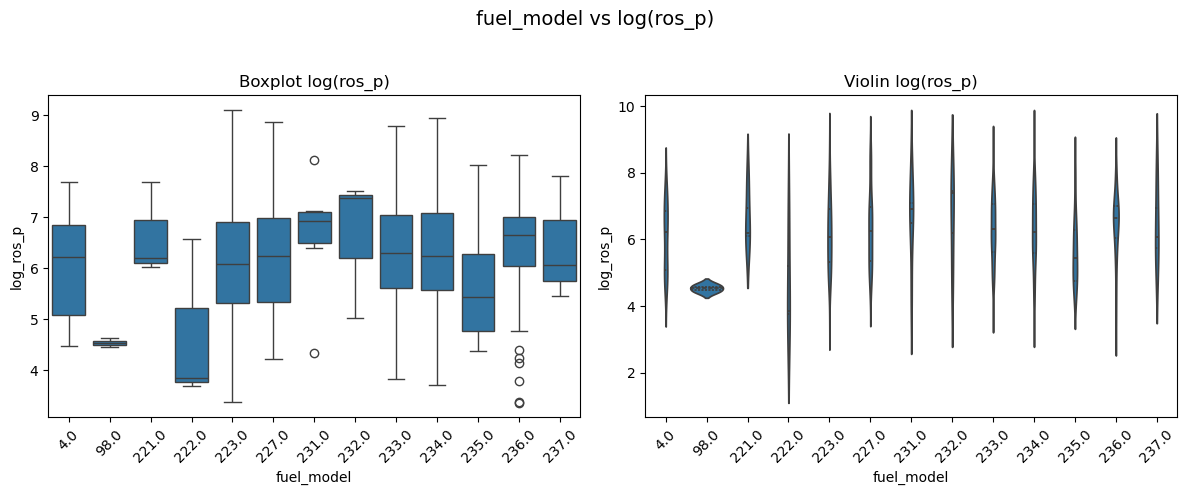

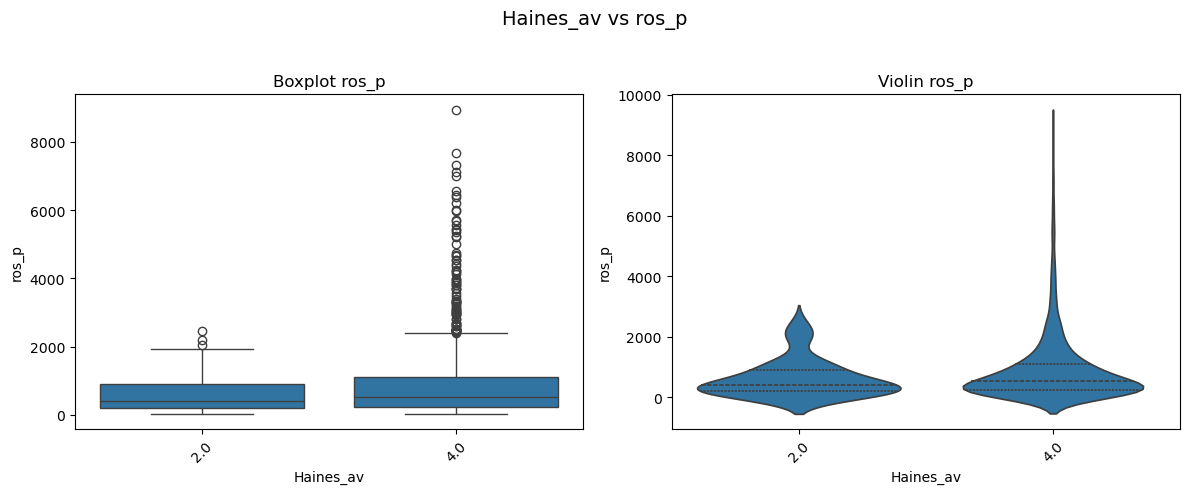

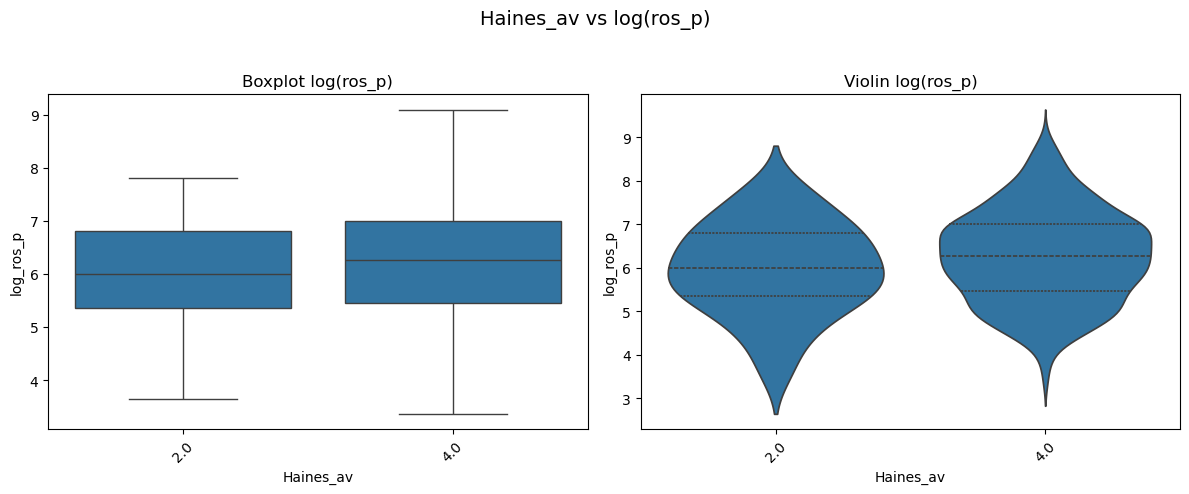


===== Heatmap p-values par-a-par (landform) =====


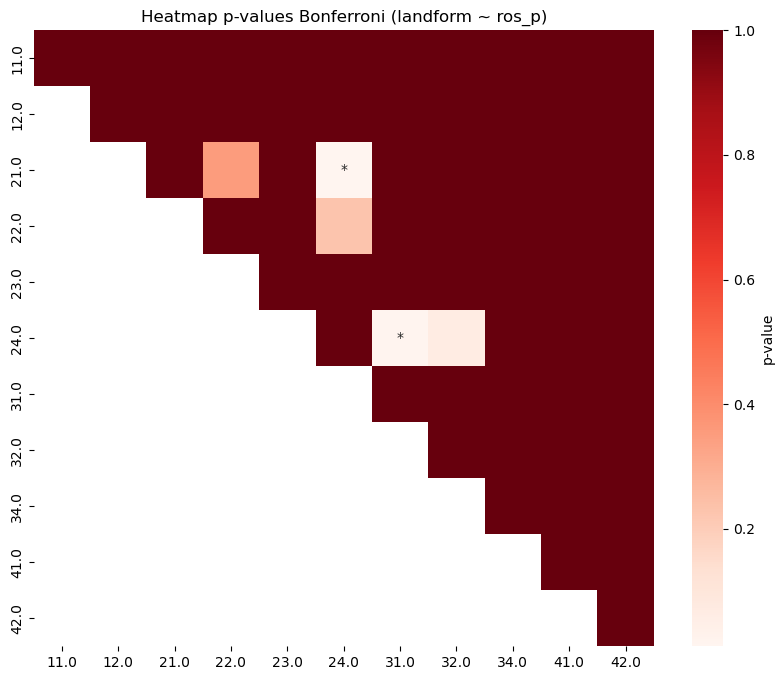

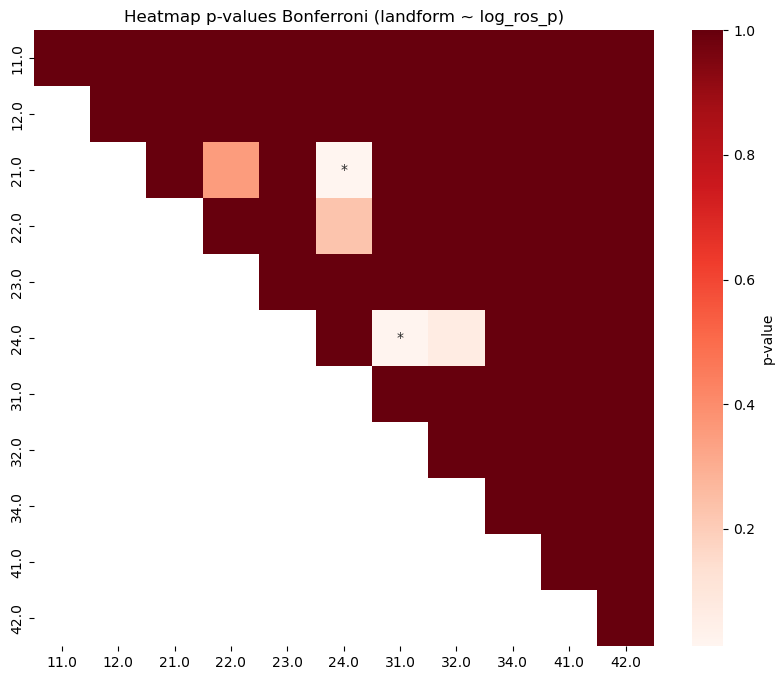


===== Heatmap p-values par-a-par (land_use) =====


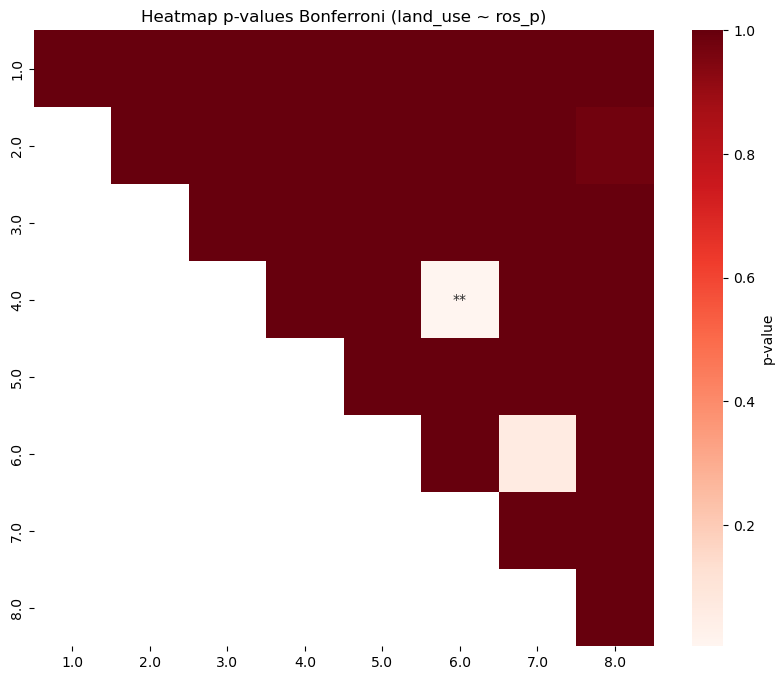

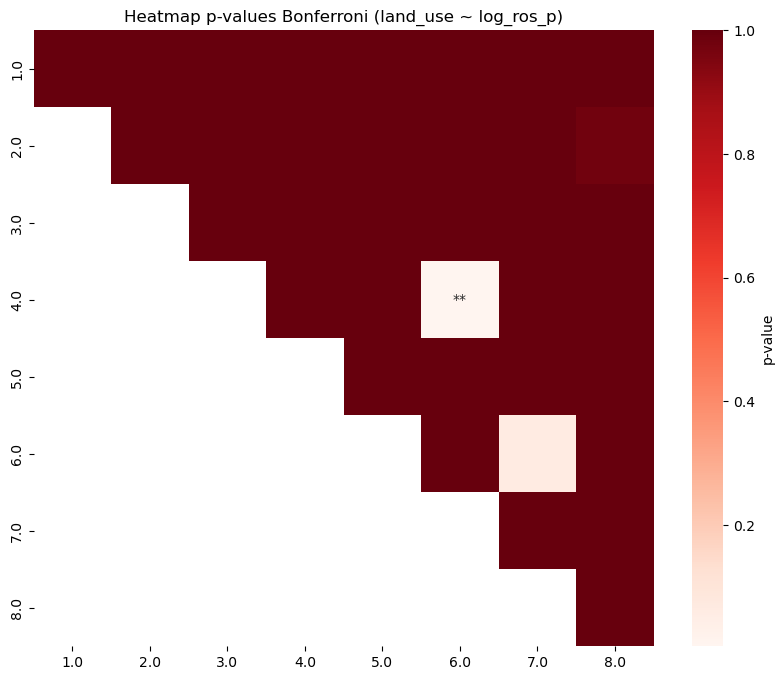


===== Heatmap p-values par-a-par (fuel_model) =====


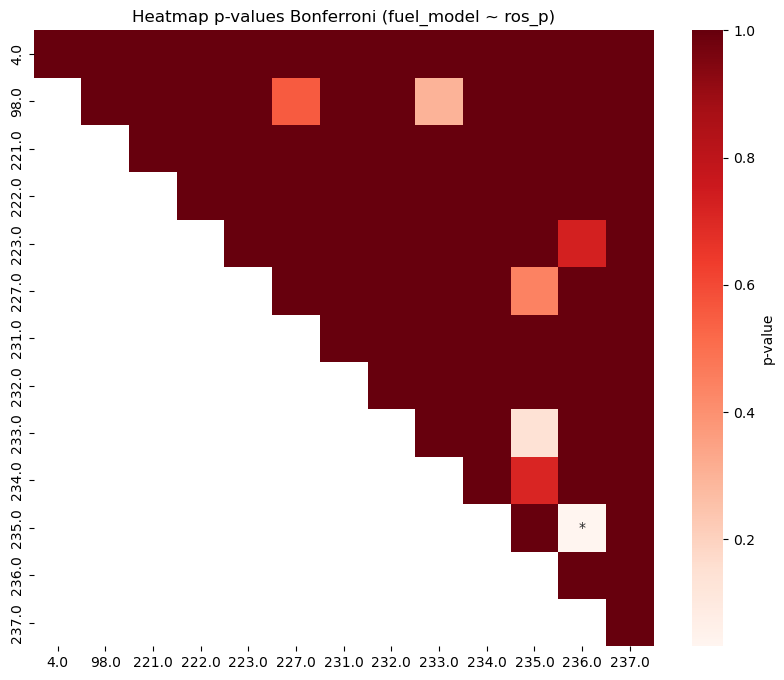

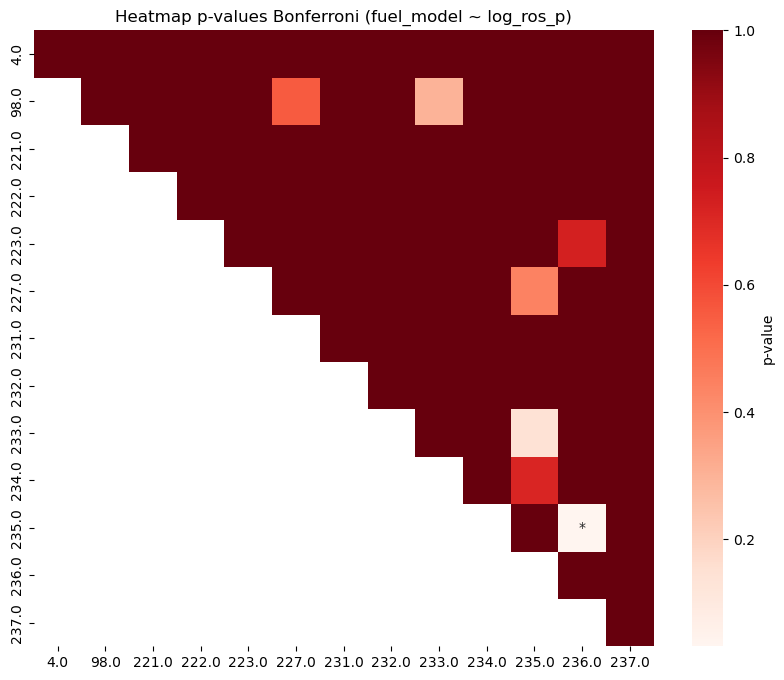


===== Heatmap p-values par-a-par (Haines_av) =====


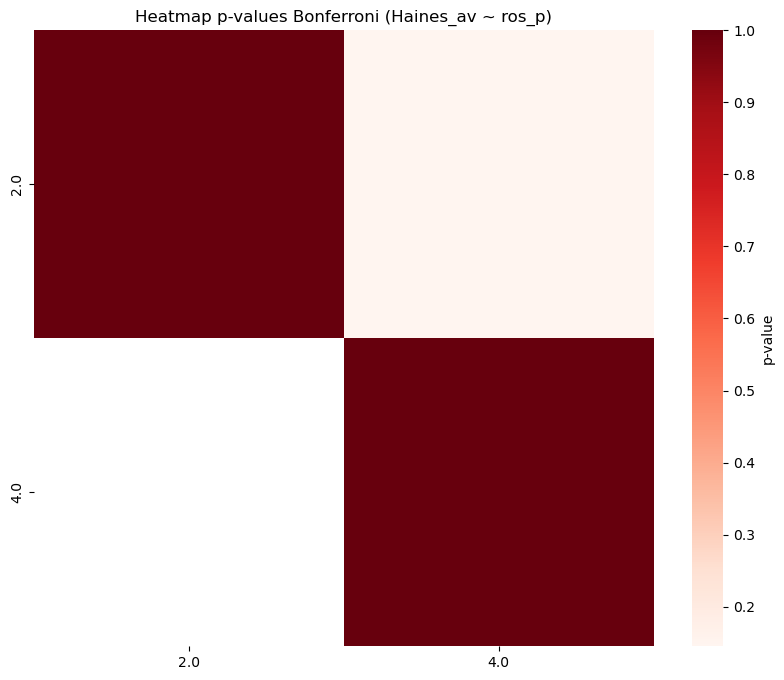

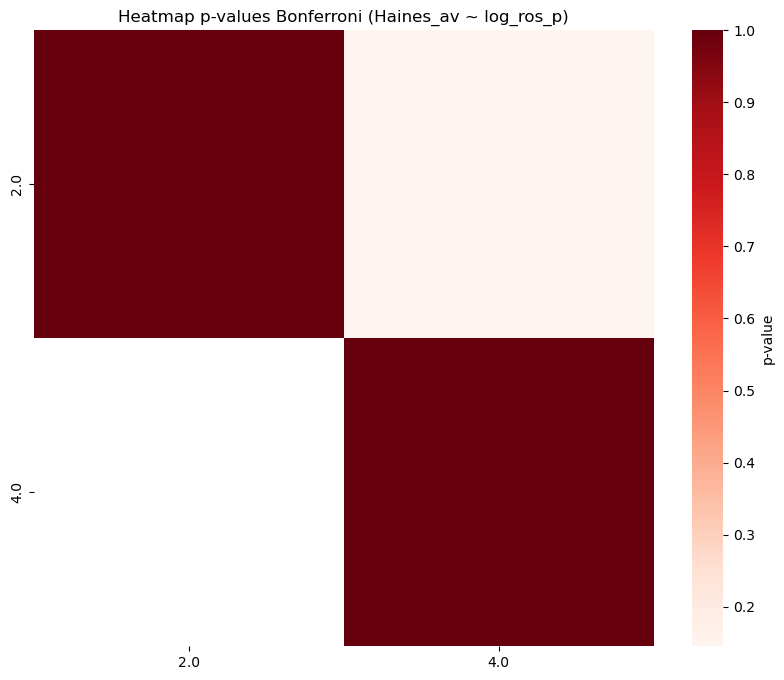

In [25]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# ============================
# 1. Carregar dados
# ============================
gdf = gpd.read_file("../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp")

# ============================
# 2. Preparar dataframe
# ============================
df = gdf[['landform', 'land_use', 'fuel_model', 'Haines_av', 'ros_p']].dropna()

# Criar log(ros_p) (evitando log(0))
df["log_ros_p"] = np.log(df["ros_p"].replace(0, np.nan))
df = df.dropna(subset=["log_ros_p"])

categoricas = ["landform", "land_use", "fuel_model", "Haines_av"]

# ============================
# 3. Testes de hipótese (Kruskal-Wallis)
# ============================

print("\n==================== TESTES DE HIPÓTESE ====================\n")

for var in categoricas:

    print(f"\n===== {var} ~ ros_p =====")
    groups = [grp["ros_p"].values for name, grp in df.groupby(var)]
    H, p = stats.kruskal(*groups)
    print(f"Kruskal-Wallis H = {H:.4f}, p = {p:.6f}")

    print(f"\n===== {var} ~ log(ros_p) =====")
    groups_log = [grp["log_ros_p"].values for name, grp in df.groupby(var)]
    H, p = stats.kruskal(*groups_log)
    print(f"Kruskal-Wallis H = {H:.4f}, p = {p:.6f}")

# ============================
# 4. Visualização com Boxplot e Violin
# ============================

for var in categoricas:

    # Plot ros_p
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{var} vs ros_p", fontsize=14)

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=var, y="ros_p")
    plt.xticks(rotation=45)
    plt.title("Boxplot ros_p")

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x=var, y="ros_p", inner='quartile')
    plt.xticks(rotation=45)
    plt.title("Violin ros_p")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

    # Plot log(ros_p)
    plt.figure(figsize=(12, 5))
    plt.suptitle(f"{var} vs log(ros_p)", fontsize=14)

    plt.subplot(1, 2, 1)
    sns.boxplot(data=df, x=var, y="log_ros_p")
    plt.xticks(rotation=45)
    plt.title("Boxplot log(ros_p)")

    plt.subplot(1, 2, 2)
    sns.violinplot(data=df, x=var, y="log_ros_p", inner='quartile')
    plt.xticks(rotation=45)
    plt.title("Violin log(ros_p)")

    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.show()

# ============================
# 5. Heatmaps com significância
# ============================

for var in categoricas:
    print(f"\n===== Heatmap p-values par-a-par ({var}) =====")
    categorias = sorted(df[var].unique())

    # Criar matriz de p-values
    pvals_ros = pd.DataFrame(index=categorias, columns=categorias, dtype=float)
    pvals_log = pd.DataFrame(index=categorias, columns=categorias, dtype=float)

    n_comparacoes = len(categorias)*(len(categorias)-1)/2  # Bonferroni

    for i, cat1 in enumerate(categorias):
        for j, cat2 in enumerate(categorias):
            if i < j:
                x1 = df[df[var]==cat1]["ros_p"]
                x2 = df[df[var]==cat2]["ros_p"]
                _, pval = stats.mannwhitneyu(x1, x2, alternative='two-sided')
                pval_bonf = min(pval*n_comparacoes,1)
                pvals_ros.loc[cat1, cat2] = pval_bonf

                x1_log = df[df[var]==cat1]["log_ros_p"]
                x2_log = df[df[var]==cat2]["log_ros_p"]
                _, pval_log = stats.mannwhitneyu(x1_log, x2_log, alternative='two-sided')
                pval_log_bonf = min(pval_log*n_comparacoes,1)
                pvals_log.loc[cat1, cat2] = pval_log_bonf

            elif i==j:
                pvals_ros.loc[cat1, cat2] = 1
                pvals_log.loc[cat1, cat2] = 1

    # Função para marcar significância
    def mark_significance(df_p):
        df_annot = df_p.copy().astype(str)
        for i in df_p.index:
            for j in df_p.columns:
                val = df_p.loc[i,j]
                if val < 0.001:
                    df_annot.loc[i,j] = '***'
                elif val < 0.01:
                    df_annot.loc[i,j] = '**'
                elif val < 0.05:
                    df_annot.loc[i,j] = '*'
                else:
                    df_annot.loc[i,j] = ''
        return df_annot

    # Heatmap ros_p
    plt.figure(figsize=(10,8))
    sns.heatmap(pvals_ros.astype(float), annot=mark_significance(pvals_ros), fmt='', cmap="Reds", cbar_kws={'label':'p-value'})
    plt.title(f"Heatmap p-values Bonferroni ({var} ~ ros_p)")
    plt.show()

    # Heatmap log_ros_p
    plt.figure(figsize=(10,8))
    sns.heatmap(pvals_log.astype(float), annot=mark_significance(pvals_log), fmt='', cmap="Reds", cbar_kws={'label':'p-value'})
    plt.title(f"Heatmap p-values Bonferroni ({var} ~ log_ros_p)")
    plt.show()



Frequência das classes:
 aspect_av_class
S     223
O     184
NO    168
SO    164
SE    151
E     115
N      84
NE     84
Name: count, dtype: int64

>>> Kruskal-Wallis (teste global)
ros_p: H = 19.2904, p = 0.007325
log_ros_p: H = 19.2904, p = 0.007325

P-values par-a-par (ros_p, Bonferroni ajustado):
       E         N         NE         NO         O          S         SE  \
E   1.0  0.769949  22.462302   0.778974  4.948885  19.041726  13.864492   
N   NaN  1.000000   0.988667  27.692828  8.170634   0.205063   0.160842   
NE  NaN       NaN   1.000000   0.737721  4.157543  25.988993  23.841991   
NO  NaN       NaN        NaN   1.000000  7.151738   0.124291   0.100388   
O   NaN       NaN        NaN        NaN  1.000000   1.833849   1.141505   
S   NaN       NaN        NaN        NaN       NaN   1.000000  19.848564   
SE  NaN       NaN        NaN        NaN       NaN        NaN   1.000000   
SO  NaN       NaN        NaN        NaN       NaN        NaN        NaN   

           SO  
E   

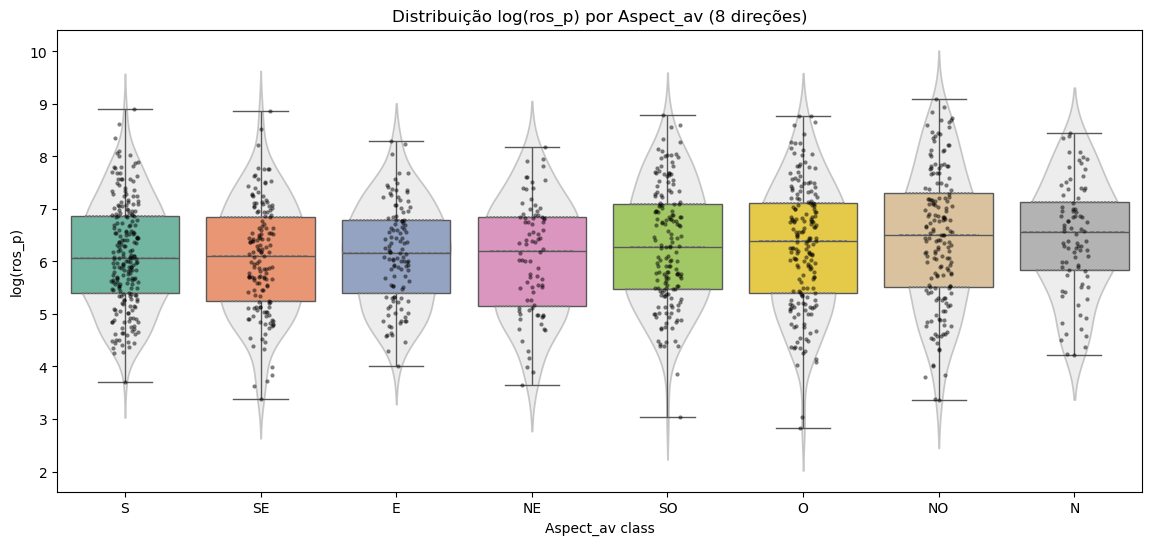

In [26]:
import geopandas as gpd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings("ignore")

# 1. Carregar dados
gdf = gpd.read_file("../../Data/Processed/PT-FireSprd_v2.1/L2_FireBehavior/PT-FireProg_v2.1_L2_model.shp")

# 2. Preparar dataframe
df = gdf[['aspect_av', 'ros_p']].dropna()

# Criar log(ros_p)
df["log_ros_p"] = np.log(df["ros_p"].replace(0, np.nan))
df = df.dropna(subset=["log_ros_p"])

# 3. Criar classes de orientação (8 direções)
bins = [-0.1, 22.5, 67.5, 112.5, 157.5, 202.5, 247.5, 292.5, 337.5, 360.1]
labels_temp = ["N", "NE", "E", "SE", "S", "SO", "O", "NO", "N2"]
df["aspect_av_class"] = pd.cut(df["aspect_av"], bins=bins, labels=labels_temp, right=False)
df["aspect_av_class"] = df["aspect_av_class"].replace({"N2": "N"})

print("\nFrequência das classes:\n", df["aspect_av_class"].value_counts())

# 4. Testes de Hipótese Globais (Kruskal-Wallis)
print("\n>>> Kruskal-Wallis (teste global)")
groups = [grp["ros_p"].values for name, grp in df.groupby("aspect_av_class")]
H, p = stats.kruskal(*groups)
print(f"ros_p: H = {H:.4f}, p = {p:.6f}")

groups_log = [grp["log_ros_p"].values for name, grp in df.groupby("aspect_av_class")]
H, p = stats.kruskal(*groups_log)
print(f"log_ros_p: H = {H:.4f}, p = {p:.6f}")

# 5. Post-hoc simplificado (comparações par-a-par)
categories = sorted(df["aspect_av_class"].unique())  # corrigido

# Criar tabela de p-values par-a-par (Mann-Whitney)
pvals_ros = pd.DataFrame(index=categories, columns=categories, dtype=float)
pvals_log = pd.DataFrame(index=categories, columns=categories, dtype=float)

for i, cat1 in enumerate(categories):
    for j, cat2 in enumerate(categories):
        if i < j:
            x1 = df[df["aspect_av_class"] == cat1]["ros_p"]
            x2 = df[df["aspect_av_class"] == cat2]["ros_p"]
            _, pval = stats.mannwhitneyu(x1, x2, alternative='two-sided')
            pvals_ros.loc[cat1, cat2] = pval * len(categories)*(len(categories)-1)/2  # Bonferroni
            x1_log = df[df["aspect_av_class"] == cat1]["log_ros_p"]
            x2_log = df[df["aspect_av_class"] == cat2]["log_ros_p"]
            _, pval_log = stats.mannwhitneyu(x1_log, x2_log, alternative='two-sided')
            pvals_log.loc[cat1, cat2] = pval_log * len(categories)*(len(categories)-1)/2  # Bonferroni
        elif i == j:
            pvals_ros.loc[cat1, cat2] = 1
            pvals_log.loc[cat1, cat2] = 1

print("\nP-values par-a-par (ros_p, Bonferroni ajustado):\n", pvals_ros)
print("\nP-values par-a-par (log_ros_p, Bonferroni ajustado):\n", pvals_log)

# 6. Ordenar categorias por mediana de log_ros_p
ordem_mediana = df.groupby("aspect_av_class")["log_ros_p"].median().sort_values().index.tolist()

# 7. Visualização aprimorada
plt.figure(figsize=(14,6))
sns.boxplot(data=df, x="aspect_av_class", y="log_ros_p", order=ordem_mediana, palette="Set2")
sns.violinplot(data=df, x="aspect_av_class", y="log_ros_p", order=ordem_mediana,
               inner="quartile", color="lightgray", alpha=0.4)
sns.stripplot(data=df, x="aspect_av_class", y="log_ros_p", order=ordem_mediana,
              color='black', size=3, alpha=0.5, jitter=True)
plt.title("Distribuição log(ros_p) por Aspect_av (8 direções)")
plt.ylabel("log(ros_p)")
plt.xlabel("Aspect_av class")
plt.show()


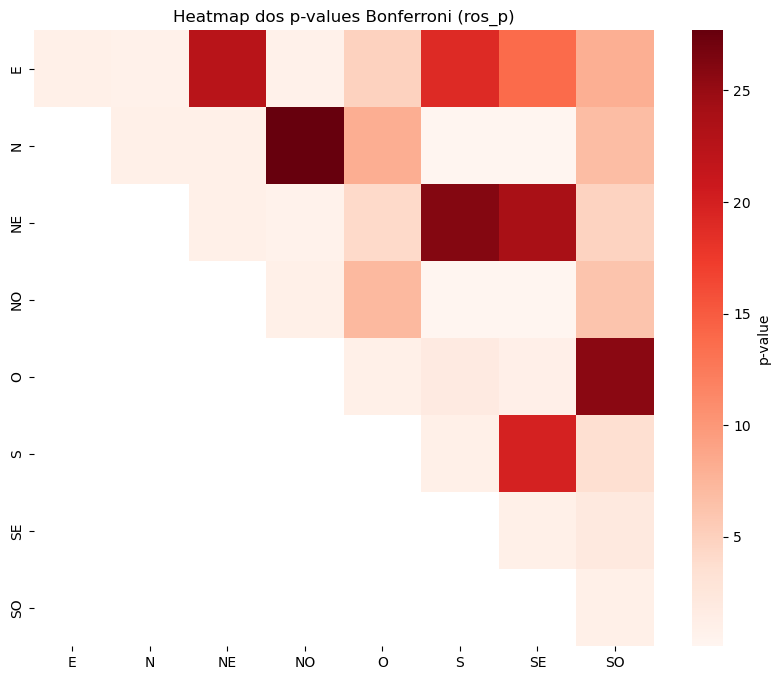

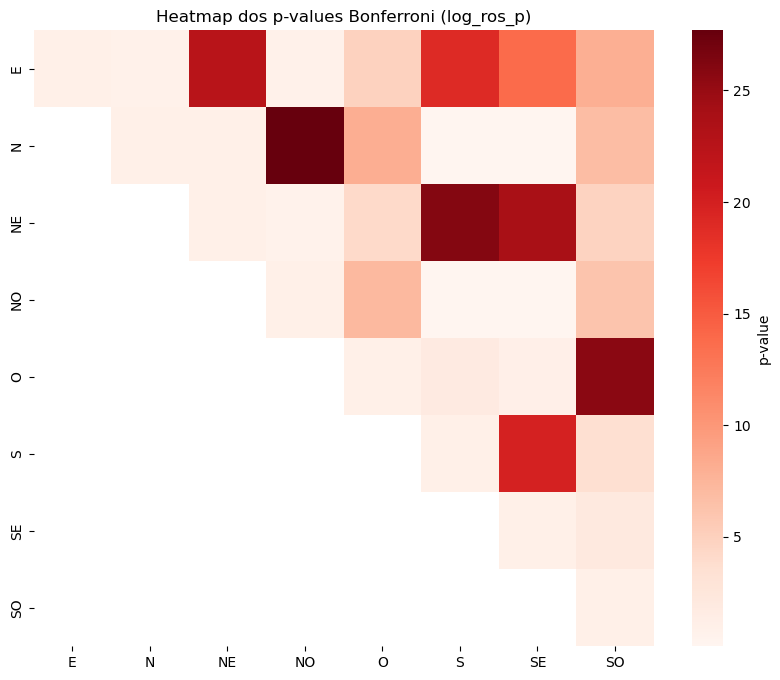

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Função para marcar significância
def mark_significance(df_p):
    df_annot = df_p.copy().astype(str)
    for i in df_p.index:
        for j in df_p.columns:
            val = df_p.loc[i,j]
            if val < 0.001:
                df_annot.loc[i,j] = '***'
            elif val < 0.01:
                df_annot.loc[i,j] = '**'
            elif val < 0.05:
                df_annot.loc[i,j] = '*'
            else:
                df_annot.loc[i,j] = ''
    return df_annot

# Heatmap para ros_p
plt.figure(figsize=(10,8))
sns.heatmap(pvals_ros.astype(float), annot=mark_significance(pvals_ros), fmt='', cmap="Reds", cbar_kws={'label':'p-value'})
plt.title("Heatmap dos p-values Bonferroni (ros_p)")
plt.show()

# Heatmap para log_ros_p
plt.figure(figsize=(10,8))
sns.heatmap(pvals_log.astype(float), annot=mark_significance(pvals_log), fmt='', cmap="Reds", cbar_kws={'label':'p-value'})
plt.title("Heatmap dos p-values Bonferroni (log_ros_p)")
plt.show()
